In [62]:
import numpy as np
import pandas as pd
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tqdm
import threading

## Input Image

In [63]:
path = './stage1_train/stage1_train/TCGA-21-5784-01Z-00-DX1/'

In [64]:
img_dir = path + 'images/'
img_data = imread(img_dir + os.listdir(img_dir)[0])

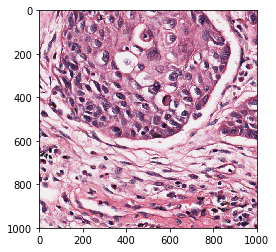

In [65]:
plt.imshow(img_data)

## Predict Mask

In [66]:
mask_dir = path + 'masks/'
masks = np.zeros((1000, 1000), dtype=np.uint16)

for index, file in enumerate(os.listdir(mask_dir)):
    mask = imread(mask_dir + file, dtype=np.uint16)
    mask[mask > 0] = index + 1
    masks += mask

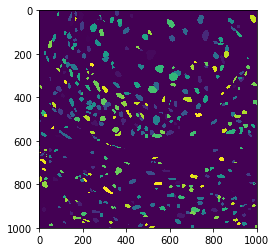

In [67]:
plt.imshow(masks)

## Calculate the score

In [68]:
mask_dir = path + 'masks/'
mask_list = []

for index, file in enumerate(os.listdir(mask_dir)):
    mask = imread(mask_dir + file, dtype=np.uint16)
    mask_list.append(mask)

mask_list = np.array(mask_list).transpose((1, 2, 0))

In [69]:
masks.shape

(1000, 1000)

In [70]:
mask_list.shape

(1000, 1000, 398)

In [71]:
# slow version of Aggregated Jaccrd Index
def agg_jc_index(mask, pred):
    """Calculate aggregated jaccard index for prediction & GT mask
    reference paper here: https://www.dropbox.com/s/j3154xgkkpkri9w/IEEE_TMI_NuceliSegmentation.pdf?dl=0

    mask: Ground truth mask, shape = [1000, 1000, instances]
    pred: Prediction mask, shape = [1000,1000], dtype = uint16, each number represent one instance

    Returns: Aggregated Jaccard index for GT & mask 
    """

    c = 0 # count intersection
    u = 0 # count union
    tqdm.monitor_interval = 0 # disable tqdm monitor to prevent warning message
    pred_instance = pred.max() # predcition instance number
    pred_mark_used = [] # mask used
    
    for idx_m in tqdm_notebook(range(len(mask[0,0,:]))):
        m = mask[:,:,idx_m]
        intersect_list = []
        union_list = []
        iou_list = []
        
        for idx_pred in range(1, pred_instance+1):
            p = (pred == idx_pred)

            # replace multiply with bool operation 
            intersect = np.count_nonzero((m!=0) & p)
            union = np.count_nonzero(m!=0) + np.count_nonzero(p) - intersect
            intersect_list.append(intersect)
            union_list.append(union)
            
        iou_list = np.array(intersect_list) / np.array(union_list)    
        hit_idx = np.argmax(np.array(iou_list))
        c += intersect_list[hit_idx]
        u += union_list[hit_idx]
        pred_mark_used.append(hit_idx)
        
    pred_mark_used = [x+1 for x in pred_mark_used]
    pred_fp = set(np.unique(pred)) - {0} - set(pred_mark_used)
    pred_fp_pixel = np.sum([np.sum(pred==i) for i in pred_fp])

    u += pred_fp_pixel
    print (c / u)
    return (c / u)

In [72]:
agg_jc_index(mask_list, masks)

HBox(children=(IntProgress(value=0, max=398), HTML(value='')))


1.0


1.0